# Evaluating surface wave breaking parameterizations in WaveWatchIII

This notebook compares several well-known surface wave breaking parameterizations used in the NEMO model to the Salish Sea configuration of the WaveWatchIII model.

***

In [3]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, colors
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
from salishsea_tools import nc_tools
from tqdm.notebook import tqdm

%matplotlib inline

In [4]:
plt.rcParams['font.size'] = 12

***

### Theory

The effect of surface wave breaking on TKE ($\overline{e}$) is parameterized in terms of the surface wind forcing in NEMO in the following two ways:

   1. The surface TKE boundary condition $\overline{e}_0$ ([Madec et al. 2017](https://zenodo.org/record/3248739), Eq. 10.10)

$$\overline{e}_0 = \frac{1}{2}\left(15.8\alpha_{CB}\right)^{2/3}\frac{\tau}{\rho_0}$$

   2. The surface dissipation length scale boundary condition $l_0$ (Charnock's relation, [Madec et al. 2017](https://zenodo.org/record/3248739), Eq. 10.11)

$$l_0 = \kappa z_0 = \kappa\beta\frac{\tau}{g\rho_0}$$

where $z_0$ is the surface roughness length, $\kappa$ is the von Kármán constant, $\tau$ is the surface wind stress, $\rho_0$ is the background seawater density, $g$ is the gravitational acceleration, and $\alpha_{CB}$ and $\beta$ are tuneable parameters. Literature values for $\alpha_{CB}$ and $\beta$ have been reported in a handful of studies (e.g., $\alpha_{CB} = 100$ [Craig and Banner 1994](https://journals.ametsoc.org/view/journals/phoc/24/12/1520-0485_1994_024_2546_mwetit_2_0_co_2.xml), $\beta = 2\times10^5$ [Stacey 1999](https://journals.ametsoc.org/view/journals/phoc/29/6/1520-0485_1999_029_1363_sotwfn_2.0.co_2.xml)).

In practice, these parameters vary widely according to sea state and fetch, and thus need to be determined specifically for the Salish Sea. One approach is to link these parameters to wind forcing using the concept of "wave age" $c_p/u_*$ ([Mellor and Blumberg 2004](https://journals.ametsoc.org/view/journals/phoc/34/3/2517.1.xml)), where $c_p$ is the surface wave phase speed and $u_*=\sqrt{\tau/\rho_{air}}$ is the air side friction velocity. The reasoning behind this concept is that $c_p$ increases relative to $u_*$ as waves develop over time. Mellor and Blumberg (2004) summarize the proposed parameter definitions across several studies as the following:

$$\alpha_{CB} = 15\frac{c_p}{u_*}\exp\left\{-\left(0.04\frac{c_p}{u_*}\right)^4\right\} \hspace{0.5cm} \text{(cited from Terray et al. 1996, 1997 JPO)}$$

$$\beta \approx 665\left(\frac{c_p}{u_*}\right)^{1.5} \hspace{0.5cm} \text{(cited from Donelan 1990, Smith et al. 1992, Janssen 2001)}$$

Craig and Banner (1994) have suggested that $l_0$ is more important in determining surface mixing than $\overline{e}_0$, and the NEMO authors agree (Madec et al. 2017). We therefore focus our initial tuning efforts on constraining the Charnock parameter $\beta$. [Rascle et al. (2008)](https://www.sciencedirect.com/science/article/abs/pii/S1463500308001017) propose an empirical fit for wave age in terms of $u_*$

$$\frac{c_p}{u_*} = A_{max}\tanh \frac{2u_{*ref}}{u_*}$$

where $A_{max}$ and $u_{*ref}$ are tuneable fit parameters. The Charnock relation is then modified in terms of the significant wave height $H_s$

$$z_0 = r_HH_s = \frac{\beta}{1}\frac{\tau}{g\rho_0}$$

where $r_{H}$ is the ratio of significant wave height $H_s$ to surface roughness length $z_0$ and can vary between approximately 0.5 and 2 as summarized by Rascle et al. (2008).

***

### Analysis

The modified Charnock relation in terms of $H_s$ given by Rascle et al. (2008) provides a framework for tuning the surface dissipation length scale parameterization for SalishSeaCast using the WaveWatch3 hindcast. Specifically, we seek to optimize the values of $A_{max}$, $u_{*ref}$ and $r_{H}$.

In [5]:
def calc_Cd(u2):
    """Calculate the surface drag coefficient according to
    Hellerman and Rosenstein (1983) JPO, neglecting T effects
    """
    
    return 0.934e-3 + 0.788e-4 * np.sqrt(u2) - 0.616e-6 * u2

Load hourly WW3 results for 2020 and spatial average over SoG water points

In [6]:
# Specify start date and SoG water points
startdate = datetime(2020, 1, 1)
slc = {'latitude': slice(160, 450), 'longitude': slice(120, 470)}
with xr.open_dataset(nc_tools.get_WW3_path(startdate)) as ds:
    mask = ds.MAPSTA.isel(slc).values.ravel().astype(bool)

# Loop through each day of hourly results files and extract variables
Hs, cp, u2 = [], [], []
for day in tqdm(range(360)):
    fn = nc_tools.get_WW3_path(startdate + timedelta(days=day))
    with xr.open_dataset(fn).isel(slc) as ds:
        hs, lm, t02, u, v = [ds[var].values.reshape(48, -1)[:, mask].mean(axis=1) for var in ('hs', 'lm', 't02', 'uwnd', 'vwnd')]
        Hs.append(hs)
        cp.append(lm/t02)
        u2.append(u**2 + v**2)

# Concatenate arrays
Hs = np.hstack(Hs)
cp = np.hstack(cp)
u2 = np.hstack(u2)

  0%|          | 0/360 [00:00<?, ?it/s]

In [7]:
# Calculate diagnostics
rho_ratio, g = 28, 9.81
ustar = np.sqrt(calc_Cd(u2) * u2)
ustar_plot = np.linspace(0.001, 1, 100)
index = ustar > 0
Hs, cp, ustar = Hs[index], cp[index], ustar[index]

In [22]:
def calc_waveage(ustar, A_max, ustar_ref):
    return A_max * np.tanh(2 * ustar_ref / ustar)
    
def calc_Hs(ustar, A_max, ustar_ref):
    return 665 * calc_waveage(ustar, A_max, ustar_ref)**(1.5) * (ustar / rho_ratio)**2 / g

p0 = [30, 0.3]
functions = {'waveage': calc_waveage, 'Hs': calc_Hs}

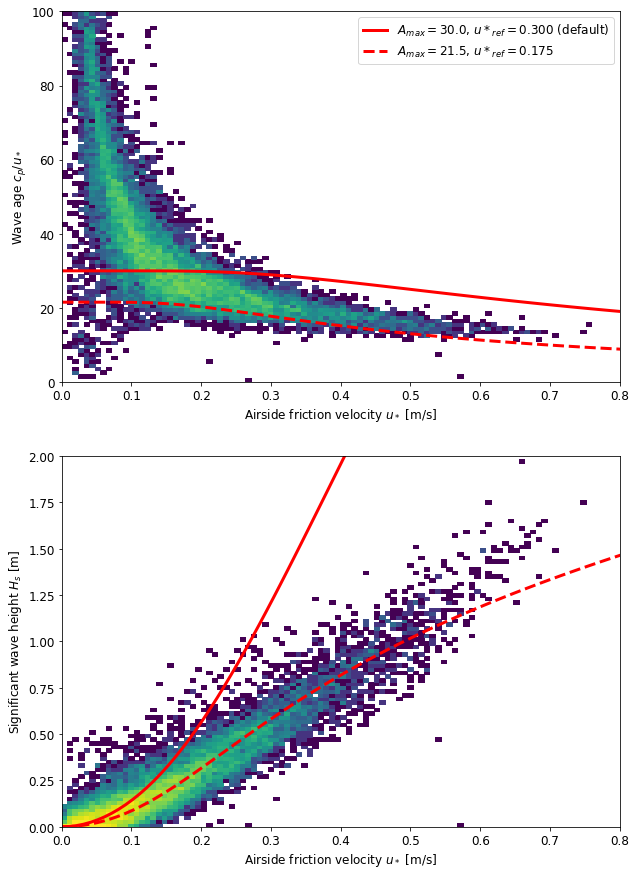

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
xlim, xlabel = [0, 0.8], 'Airside friction velocity $u_*$ [m/s]'
for ax, func, yplot, ymax, ylabel in zip(axs, ['waveage', 'Hs'], [cp/ustar, Hs], [100, 2], ['Wave age $c_p/u_*$', 'Significant wave height $H_s$ [m]']):
    ylim = [0, ymax]
    _, _, _, c = ax.hist2d(ustar, yplot, bins=100, range=[xlim, ylim], norm=colors.LogNorm(vmin=1, vmax=100))
    
    yfit = functions[func](ustar_plot, *p0)
    label = f'$A_{{max}}=${p0[0]:.1f}, $u*_{{ref}}=${p0[1]:.3f} (default)'
    ax.plot(ustar_plot, yfit, 'r-', lw=3, label=label)
    popt, pcov = curve_fit(calc_Hs, ustar, Hs, p0=p0)
    yfit = functions[func](ustar_plot, *popt)
    label = f'$A_{{max}}=${popt[0]:.1f}, $u*_{{ref}}=${popt[1]:.3f}'
    ax.plot(ustar_plot, yfit, 'r--', lw=3, label=label)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
axs[0].legend()